In [1]:
import torch
import torchvision.models as vmodels
import torchvision.transforms as vtransforms
from model import Resnet_fc_CAM
from data import get_dataloaders
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
from skimage.transform import resize

In [2]:
data_dir = "../datasets/predfaces"
batch_size = 1

train_loader, valid_loader, test_loader = get_dataloaders(data_dir, batch_size)
nb_classes = len(test_loader.dataset.classes)
idx_to_cls = {v: k for k, v in test_loader.dataset.class_to_idx.items()}

base_model = vmodels.resnet50(pretrained=False)
net = Resnet_fc_CAM(base_model=base_model, nb_classes=nb_classes)
model_path = 'experiments/baseline_fh/best.pth'
net = Resnet_fc_CAM(base_model=base_model, nb_classes=nb_classes)
net.load_state_dict(torch.load(model_path, map_location='cpu'))




IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [3]:
for idx, (inputs, targets) in enumerate(test_loader):
    net.eval()
    with torch.no_grad():
        logit = net(inputs).squeeze(-1).squeeze(-1)
    probs, prediction = logit.max(1)
#     cam = net.generate_cam(cls)
    correct = targets.eq(prediction).item()
    if correct != 1:
        print(idx, targets, torch.softmax(logit, 1))
        break

31 tensor([0]) tensor([[3.7067e-02, 3.2042e-04, 6.6683e-04, 3.0255e-03, 9.5892e-01]])


In [4]:
def imference_with_cam(model, img, cls):
    
    model.eval()
    with torch.no_grad():
        logit = model(img.unsqueeze(0)).squeeze(-1).squeeze(-1)
    _, prediction = logit.max(1)
    cam = model.generate_cam(prediction)
    return logit, prediction.item(), cam[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

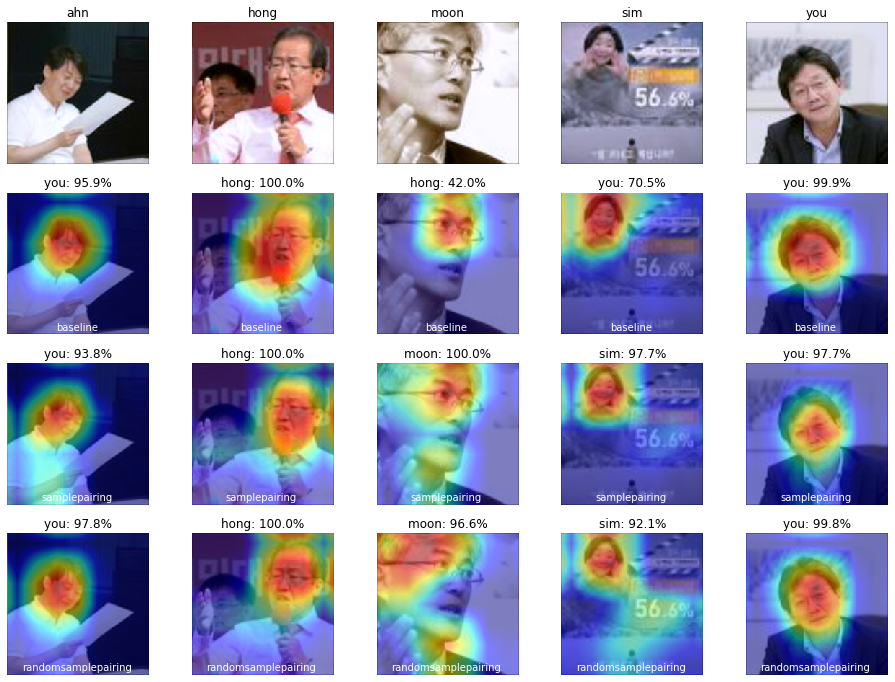

In [5]:
def make_cam(idx_list):

    # https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/4
    inv_normalize = vtransforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
        std=[1/0.229, 1/0.224, 1/0.255]
    )

    img_list = [test_loader.dataset[idx][0] for idx in idx_list]
    cls_list = [0, 1, 2, 3, 4]

    fig, ax = plt.subplots(4, 5, figsize=(16, 12), facecolor='white')
    for jdx, img in enumerate(img_list):
        original_img = inv_normalize(img).cpu().numpy().transpose(1, 2, 0)

        ax[0][jdx].imshow(original_img)
        ax[0][jdx].axis("off")
        ax[0][jdx].set_title(idx_to_cls[cls_list[jdx]])

    for idx, experiment in enumerate(['baseline', 'samplepairing', 'randomsamplepairing']):
        model_path = 'experiments/{}_fh/best.pth'.format(experiment)
        net = Resnet_fc_CAM(base_model=base_model, nb_classes=nb_classes)
        net.load_state_dict(torch.load(model_path, map_location='cpu'))

        for img, cls in zip(img_list, cls_list):
            logit, prediction, cam = imference_with_cam(net, img, cls)
            probs = torch.softmax(logit, 1)[0]
            resized_cam = resize(cam.cpu().numpy(), (197, 197))

            original_img = inv_normalize(img).cpu().numpy().transpose(1, 2, 0)
            ax[idx+1][cls].imshow(original_img)
            ax[idx+1][cls].imshow(resized_cam, cmap='jet', alpha=0.5)
            ax[idx+1][cls].set_title("{}: {:.1f}%".format(idx_to_cls[prediction], probs[prediction] * 100))
            ax[idx+1][cls].text(96, 190, experiment, color='white', horizontalalignment='center')
            ax[idx+1][cls].axis("off")
            ax[idx+1][cls].set_xlabel("baseline")

idx_list = [31, 48, 86, 109, 138]
make_cam(idx_list)